In [1]:
#!/bin/bash
!curl -L -o  archive.zip\
https://www.kaggle.com/api/v1/datasets/download/brsdincer/vehicle-detection-image-set
!unzip archive.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/vehicles/4414.png  
  inflating: data/vehicles/4415.png  
  inflating: data/vehicles/4416.png  
  inflating: data/vehicles/4417.png  
  inflating: data/vehicles/4418.png  
  inflating: data/vehicles/4419.png  
  inflating: data/vehicles/442.png   
  inflating: data/vehicles/4420.png  
  inflating: data/vehicles/4421.png  
  inflating: data/vehicles/4422.png  
  inflating: data/vehicles/4423.png  
  inflating: data/vehicles/4424.png  
  inflating: data/vehicles/4425.png  
  inflating: data/vehicles/4426.png  
  inflating: data/vehicles/4427.png  
  inflating: data/vehicles/4428.png  
  inflating: data/vehicles/4429.png  
  inflating: data/vehicles/443.png   
  inflating: data/vehicles/4430.png  
  inflating: data/vehicles/4431.png  
  inflating: data/vehicles/4432.png  
  inflating: data/vehicles/4433.png  
  inflating: data/vehicles/4434.png  
  inflating: data/vehicles/4435.png  
  inflating: data/vehicles/4436.png  

In [25]:
import torch
import torchvision

# step 1) Dataset preparation
data_path = '/content/data'

# 1) resize the image to 256x256
# 2) Convert input image into tensor
# 3) Normalize
# Create an empty list
transform = [
 torchvision.transforms.Resize((256,256)),
 torchvision.transforms.ToTensor(),
 torchvision.transforms.Normalize(mean = [0.5,0.5,0.5],std = [0.5,0.5,0.5])] # make data less noisy

transformation = torchvision.transforms.Compose(transform)
full_dataset = torchvision.datasets.ImageFolder(root = data_path, transform = transformation) # it will go trough all the image folder


# split into training and testing data set
train_size = int(0.7*len(full_dataset)) # 70% for the train use
test_size = len(full_dataset) - train_size # 30% for validation use
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset,[train_size,test_size]) # this will randomly split into the test and train dataset


In [32]:
#step 2) setting up your data loader
batch_size = 32
# train data loader
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size = batch_size,
                                           shuffle=True)

# test data loader
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size = batch_size,
                                          shuffle=False)

In [33]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
num_epoch = 5
num_classes = 2
learning_rate = 0.001

In [34]:
#step 3) Create model

class CNN(torch.nn.Module):
  def __init__(self, num_classes=num_classes):
    super(CNN, self).__init__()
    # create 1 layer
    self.conv1 = torch.nn.Conv2d(3,64, kernel_size=5, stride=1, padding=2)
    self.batch1 = torch.nn.BatchNorm2d(64)
    self.act1 = torch.nn.ReLU()
    self.drop1 = torch.nn.Dropout2d(p = 0.2)
    self.pool1 = torch.nn.MaxPool2d(kernel_size = 2)

    # Create 2 layer
    self.conv2 = torch.nn.Conv2d(64,128, kernel_size=5, stride=1, padding=2)
    self.batch2 = torch.nn.BatchNorm2d(128)
    self.act2 = torch.nn.ReLU()
    self.drop2 = torch.nn.Dropout2d(p = 0.2)
    self.pool2 = torch.nn.MaxPool2d(kernel_size = 2 )

    # Create 2 layer
    self.conv3 = torch.nn.Conv2d(128,256, kernel_size=5, stride=1, padding=2)
    self.batch3 = torch.nn.BatchNorm2d(256)
    self.act3 = torch.nn.ReLU()
    self.drop3 = torch.nn.Dropout2d(p = 0.2)
    self.pool3 = torch.nn.MaxPool2d(kernel_size = 2 )

    self.flatten = torch.nn.Flatten()
    self.fc = torch.nn.Linear(256*32*32,out_features=num_classes)

  def forward(self,x):
    # First Convulation Layer
    out = self.conv1(x)
    out = self.batch1(out)
    out = self.act1(out)
    out = self.drop1(out)
    out = self.pool1(out)

    # # # Second Convulation Layer
    out = self.conv2(out)
    out = self.batch2(out)
    out = self.act2(out)
    out = self.drop2(out)
    out = self.pool2(out)

    out = self.conv3(out)
    out = self.batch3(out)
    out = self.act3(out)
    out = self.drop3(out)
    out = self.pool3(out)

    # flatten only done when we want to get the output
    out = self.flatten(out)
    out = self.fc(out)

    return torch.nn.functional.log_softmax(out,dim=1)


model = CNN(num_classes).to(device)
from torchsummary import summary
print(summary(model, (3,256,256)))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           4,864
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
         Dropout2d-4         [-1, 64, 256, 256]               0
         MaxPool2d-5         [-1, 64, 128, 128]               0
            Conv2d-6        [-1, 128, 128, 128]         204,928
       BatchNorm2d-7        [-1, 128, 128, 128]             256
              ReLU-8        [-1, 128, 128, 128]               0
         Dropout2d-9        [-1, 128, 128, 128]               0
        MaxPool2d-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]         819,456
      BatchNorm2d-12          [-1, 256, 64, 64]             512
             ReLU-13          [-1, 256, 64, 64]               0
        Dropout2d-14          [-1, 256,

In [35]:
# Training the model:
def test(model,test_loader,device):

  # Model evaluation to whether we want to save or train again to get better accuracy and lower loss

  # set model to evauation mode
  model.eval()
  with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
      images = images.to(device) # images here is already has the batch size since we take from the test loader
      labels = labels.to(device)
      # labels = torch.eye(num_classes)[labels].to(device)

      predicted_output = model(images)
      _,predicted = torch.max(predicted_output.data,1)    # here it will return max value in tuple and index of the max value
      total += labels.size(0)                             # increment the total we iterate
      correct += (predicted == labels).sum().item()       #summing if correct
  acc = correct/total * 100
  return acc

# Loss
criterion = torch.nn.CrossEntropyLoss()

#optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training the model
# Set the model into training mode
epoch_loss = 0
loss_list = [] # to store the losses in list
training_loss = [] # To store the epoch training loss
training_acc = [] # to store accuracy every eporch
epoch_nums = [] # Epoch number
total_step = len(train_loader)

model.train() # dont forget to put this if not the model is not training


for epoch in range(num_epoch): # how many in one epoch can be calculate by datasize/batch_size

  for i, (images, labels) in enumerate(train_loader):
    model.train()
    images = images.to(device)
    labels = torch.eye(num_classes)[labels].to(device)

    # Forward pass
    outputs = model(images)
    loss = criterion(outputs,labels)

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # To calculate the loss
    epoch_loss = epoch_loss + loss.item() # summing up the epoch lost of every step in epoch
    loss_list.append(epoch_loss)

    # Print out the loss for every step
    if (i + 1) % 5000 == 0:
      print('Epoch [{}/{}], Step [{}/{}], Loss {:.4f}'.format(epoch+1,num_epoch,i+1,total_step,loss.item()))

  # Training loss
  avg_loss = epoch_loss / (i+1)
  training_loss.append(avg_loss)
  # Accuracy
  accuracy = test(model, test_loader, device)
  training_acc.append(accuracy)

  epoch_nums.append(epoch)
  epoch_loss = 0



[84.45945945945947, 94.7072072072072, 98.23573573573574, 97.3536036036036, 98.1418918918919]


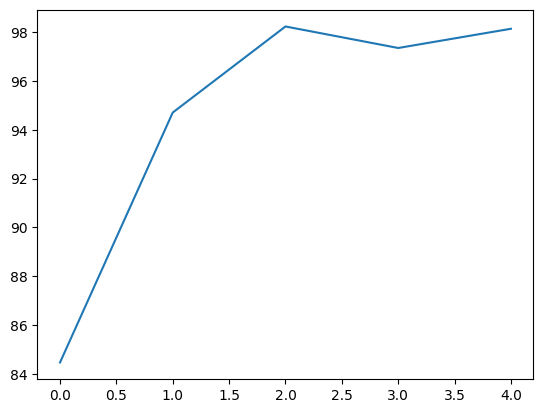






[[2685   11]
 [  88 2544]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2696
           1       1.00      0.97      0.98      2632

    accuracy                           0.98      5328
   macro avg       0.98      0.98      0.98      5328
weighted avg       0.98      0.98      0.98      5328



In [38]:
#step 3) Model evaluation

# Plot the graph
import matplotlib.pyplot as plt
print(training_acc)
plt.plot(epoch_nums, training_acc)
plt.show()


print("\n\n\n\n")
from sklearn.metrics import confusion_matrix, classification_report



# Ensure the model is on the same device as the inputs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

y_pred = []
y_true = []

for images, labels in test_loader:
  images, labels = images.to(device), labels.to(device)  # Move images and labels to the same device as the model
  predicted_output = model(images)  #input into model become images

  _,predicted = torch.max(predicted_output,1)
  y_pred.extend(predicted.data.cpu().numpy())

  labels = labels.data.cpu().numpy()
  y_true.extend(labels)

cf_matrix = confusion_matrix(y_true,y_pred)
print(cf_matrix)
print(classification_report(y_true,y_pred))

[84.45945945945947, 94.7072072072072, 98.23573573573574, 97.3536036036036, 98.1418918918919]


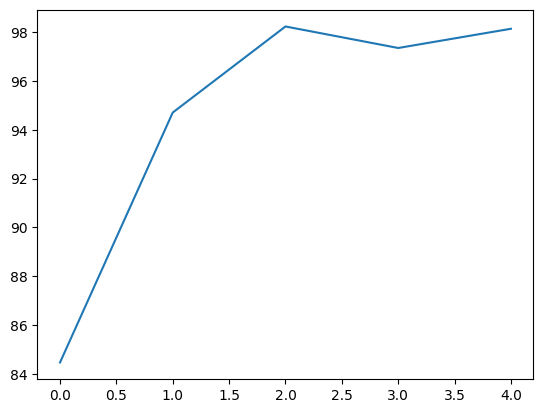






[[2685   11]
 [  88 2544]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2696
           1       1.00      0.97      0.98      2632

    accuracy                           0.98      5328
   macro avg       0.98      0.98      0.98      5328
weighted avg       0.98      0.98      0.98      5328



In [37]:
#step 3) Model evaluation

# Plot the graph
import matplotlib.pyplot as plt
print(training_acc)
plt.plot(epoch_nums, training_acc)
plt.show()


print("\n\n\n\n")
from sklearn.metrics import confusion_matrix, classification_report



# Ensure the model is on the same device as the inputs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

y_pred = []
y_true = []

# Iterate through the test loader
for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)  # Move images and labels to the same device as the model

    # Perform predictions
    predicted_output = model(images)
    _, predicted = torch.max(predicted_output, 1)

    # Move predictions and labels to the CPU and convert to NumPy arrays
    y_pred.extend(predicted.cpu().numpy())
    y_true.extend(labels.cpu().numpy())

# Compute the confusion matrix and classification report
cf_matrix = confusion_matrix(y_true, y_pred)
print(cf_matrix)
print(classification_report(y_true, y_pred))


In [40]:
torch.save(model.state_dict(),'project_3layer_98%_cnn.pt')